In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# List folders in your main Google Drive
os.listdir('/content/drive/My Drive')


['Aptos2018.zip', 'Colab Notebooks']

In [ ]:
!unzip "/content/drive/My Drive/Aptos2018.zip" -d "/content/aptos_data"


Archive:  /content/drive/My Drive/Aptos2018.zip
   creating: /content/aptos_data/Aptos2018/
  inflating: /content/aptos_data/Aptos2018/test.csv  
   creating: /content/aptos_data/Aptos2018/test_images/
  inflating: /content/aptos_data/Aptos2018/test_images/e4dcca36ceb4.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e4e343eaae2a.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e4f12411fd85.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e50b0174690d.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e5197d77ec68.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e529c5757d64.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e52ed5c29c5e.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e540d2e35d15.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e55188915f9d.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e580676516b0.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e58

In [ ]:
import os
os.listdir('/content/aptos_data/Aptos2018/')


['test.csv',
 'val_images',
 'test_images',
 'train_images',
 'train.csv',
 'valid.csv']

In [ ]:
train_csv = '/content/aptos_data/Aptos2018/train.csv'
val_csv = '/content/aptos_data/Aptos2018/valid.csv'
train_dir = '/content/aptos_data/Aptos2018/train_images'
val_dir = '/content/aptos_data/Aptos2018/val_images'


In [ ]:
import os

print("Train CSV found:", os.path.exists(train_csv))
print("Train Images:", len(os.listdir(train_dir)))
print("Validation Images:", len(os.listdir(val_dir)))


Train CSV found: True
Train Images: 2930
Validation Images: 366


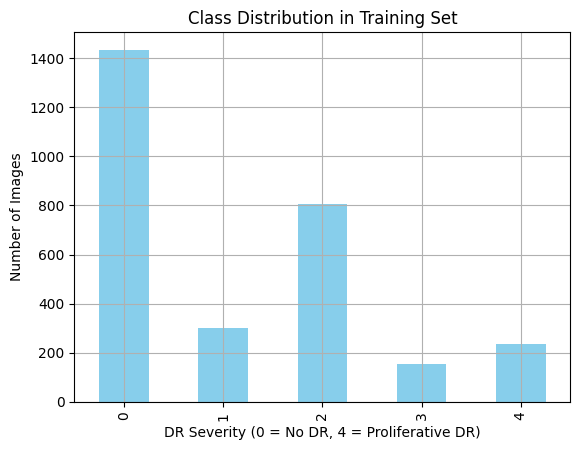

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

# Check class distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Class Distribution in Training Set")
plt.xlabel("DR Severity (0 = No DR, 4 = Proliferative DR)")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()


In [ ]:
base_path = '/content/aptos_data/Aptos2018'

train_csv = f'{base_path}/train.csv'
val_csv = f'{base_path}/valid.csv'

train_dir = f'{base_path}/train_images'
val_dir = f'{base_path}/val_images'


In [ ]:
import pandas as pd

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

print("Train Data:")
print(train_df.head())

print("\nValidation Data:")
print(val_df.head())


Train Data:
        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0

Validation Data:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


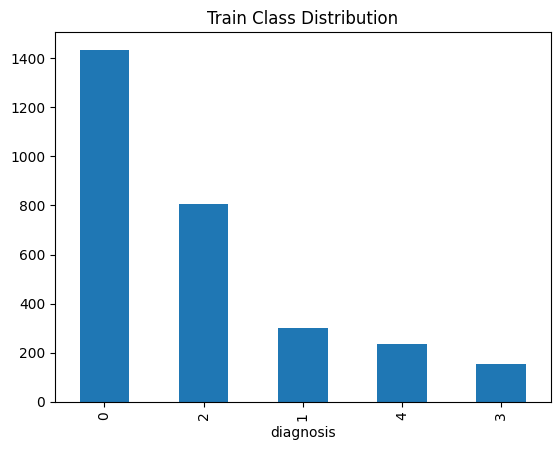

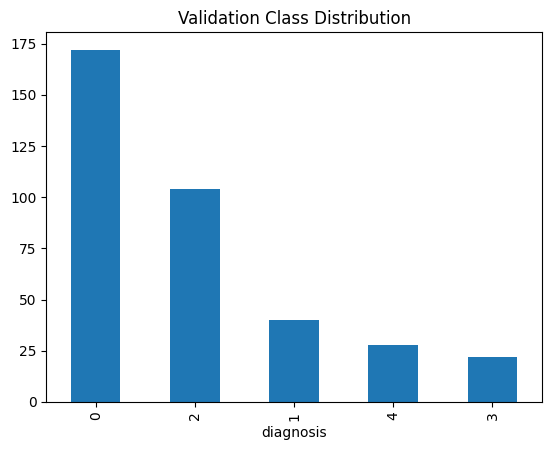

In [ ]:
import matplotlib.pyplot as plt

train_df['diagnosis'].value_counts().plot(kind='bar', title='Train Class Distribution')
plt.show()

val_df['diagnosis'].value_counts().plot(kind='bar', title='Validation Class Distribution')
plt.show()


In [ ]:
!pip install -q albumentations


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])


In [ ]:
import cv2
from torch.utils.data import Dataset

class DRDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.iloc[index]['id_code'] + '.png'
        label = self.df.iloc[index]['diagnosis']
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label


In [ ]:
from torch.utils.data import DataLoader

train_dataset = DRDataset(train_df, train_dir, transform=train_transform)
val_dataset = DRDataset(val_df, val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
!pip install -q timm

import torch
import torch.nn as nn
import timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.0 MB/s eta 0:00:00


In [ ]:
class HybridModel(nn.Module):
    def __init__(self, num_classes=5):
        super(HybridModel, self).__init__()

        # Load pretrained EfficientNet B0
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)

        # Load pretrained ResNet18
        self.resnet = timm.create_model('resnet18', pretrained=True, num_classes=0)

        # Freeze base models (optional)
        # for param in self.efficientnet.parameters():
        #     param.requires_grad = False
        # for param in self.resnet.parameters():
        #     param.requires_grad = False

        # Feature dimensions from both models
        self.efficientnet_out = self.efficientnet.num_features  # 1280
        self.resnet_out = self.resnet.num_features              # 512

        # Combine both features
        self.fusion = nn.Sequential(
            nn.Linear(self.efficientnet_out + self.resnet_out, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feat1 = self.efficientnet(x)  # (B, 1280)
        feat2 = self.resnet(x)        # (B, 512)

        combined = torch.cat((feat1, feat2), dim=1)  # (B, 1792)
        out = self.fusion(combined)
        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridModel(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%\n")


Epoch 1/4: 100%|██████████| 92/92 [30:25<00:00, 19.85s/it]

Train Loss: 0.8279 | Train Accuracy: 70.00%


Validation Accuracy: 77.05%



Epoch 2/4: 100%|██████████| 92/92 [29:05<00:00, 18.98s/it]

Train Loss: 0.5319 | Train Accuracy: 79.80%


Validation Accuracy: 80.87%



Epoch 3/4: 100%|██████████| 92/92 [28:41<00:00, 18.71s/it]

Train Loss: 0.4100 | Train Accuracy: 84.98%


Validation Accuracy: 81.42%



Epoch 4/4: 100%|██████████| 92/92 [28:31<00:00, 18.60s/it]

Train Loss: 0.3164 | Train Accuracy: 88.74%


Validation Accuracy: 81.42%



Accuracy: 0.8142076502732241
                  precision    recall  f1-score   support

           No DR       0.99      0.99      0.99       172
            Mild       0.62      0.70      0.66        40
        Moderate       0.73      0.77      0.75       104
          Severe       0.31      0.18      0.23        22
Proliferative DR       0.56      0.54      0.55        28

        accuracy                           0.81       366
       macro avg       0.64      0.64      0.64       366
    weighted avg       0.80      0.81      0.81       366



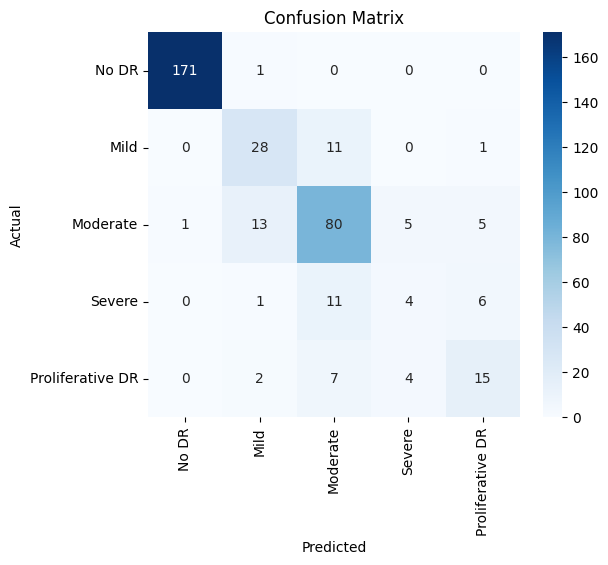

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
print("Accuracy:", accuracy_score(all_labels, all_preds))

class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']


# Detailed classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



✅ Overall Accuracy: 81.42%

📊 Classification Report:
                  precision    recall  f1-score   support

           No DR       0.99      0.99      0.99       172
            Mild       0.62      0.70      0.66        40
        Moderate       0.73      0.77      0.75       104
          Severe       0.31      0.18      0.23        22
Proliferative DR       0.56      0.54      0.55        28

        accuracy                           0.81       366
       macro avg       0.64      0.64      0.64       366
    weighted avg       0.80      0.81      0.81       366



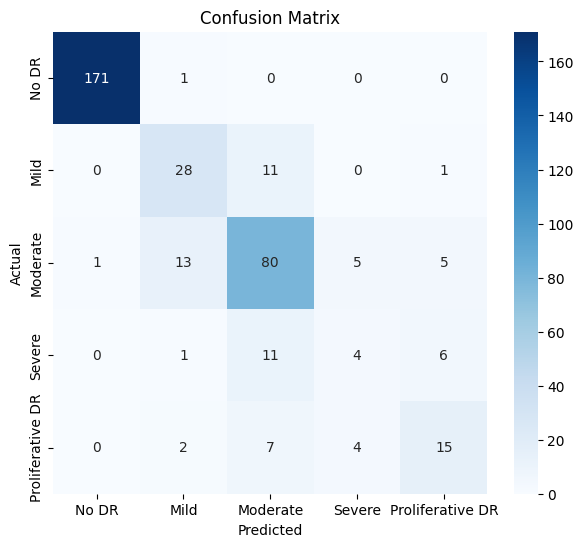

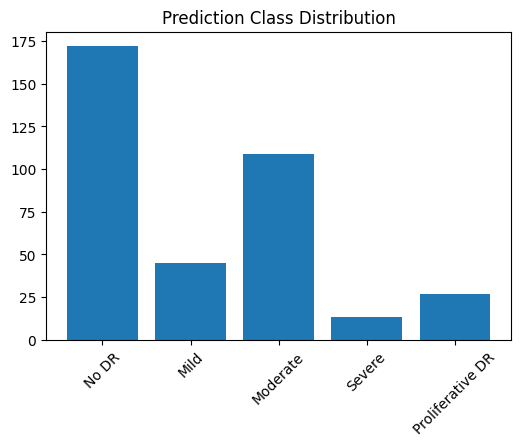


✅ Correct Predictions:


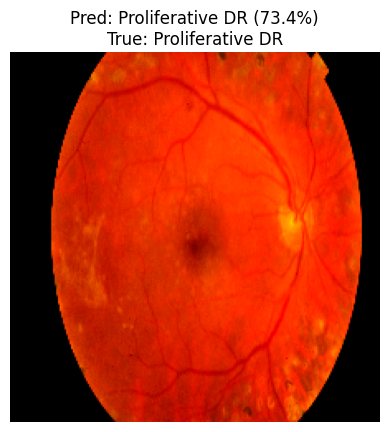

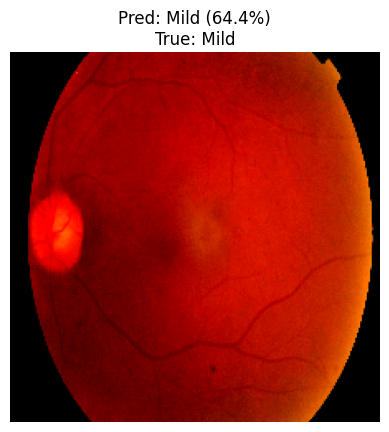


❌ Wrong Predictions:


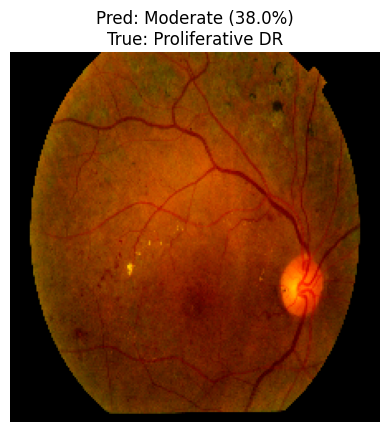

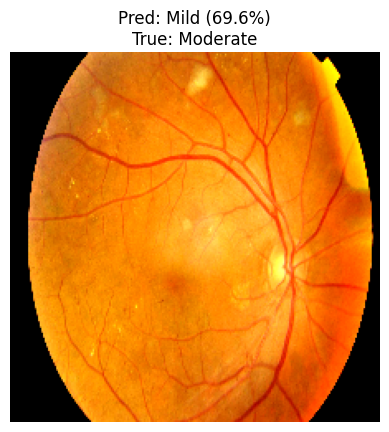

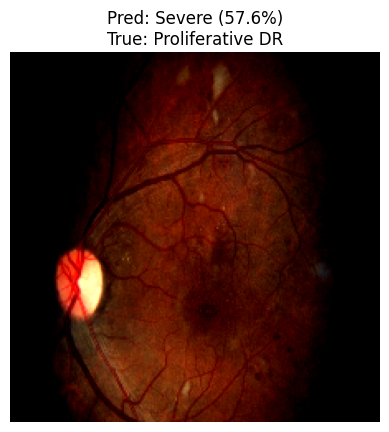

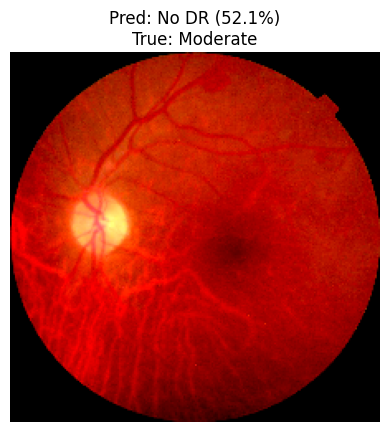

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F
from collections import Counter

def analyze_model_predictions(model, dataloader, class_names, max_images=5):
    model.eval()
    all_preds, all_labels, all_confs = [], [], []
    wrong_examples, correct_examples = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confs.extend(confs.cpu().numpy())

            for i in range(images.size(0)):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * 0.5 + 0.5  # unnormalize
                img = np.clip(img, 0, 1)
                pred_label = preds[i].item()
                true_label = labels[i].item()
                conf = confs[i].item() * 100

                if pred_label == true_label:
                    if len(correct_examples) < max_images:
                        correct_examples.append((img, pred_label, true_label, conf))
                else:
                    if len(wrong_examples) < max_images:
                        wrong_examples.append((img, pred_label, true_label, conf))

    # ✅ Accuracy & report
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Overall Accuracy: {acc*100:.2f}%\n")
    print("📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # ✅ Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ✅ Class distribution
    plt.figure(figsize=(6,4))
    pred_counts = Counter(all_preds)
    plt.bar(range(len(class_names)), [pred_counts[i] for i in range(len(class_names))])
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.title("Prediction Class Distribution")
    plt.show()

    # ✅ Show correct predictions
    print("\n✅ Correct Predictions:")
    for img, pred, true, conf in correct_examples:
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred]} ({conf:.1f}%)\nTrue: {class_names[true]}")
        plt.axis("off")
        plt.show()

    # ✅ Show wrong predictions
    print("\n❌ Wrong Predictions:")
    for img, pred, true, conf in wrong_examples:
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred]} ({conf:.1f}%)\nTrue: {class_names[true]}")
        plt.axis("off")
        plt.show()

# Example usage:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
analyze_model_predictions(model, val_loader, class_names, max_images=5)
